In [1]:
%pwd

'C:\\Users\\dagr2'

In [2]:
%cd H:\SMLDL

H:\SMLDL


In [3]:
%ls

 Volume in drive H is UGHOME01-E
 Volume Serial Number is 8452-E725

 Directory of H:\SMLDL

2020-01-11  13:27    <DIR>          .
2020-01-11  13:27    <DIR>          ..
2020-01-11  10:38    <DIR>          17flowers
2020-01-12  13:20        33 115 176 googlenet_flowers_group1.h5
2020-01-11  13:26            96 067 lab2_part1.ipynb
2020-01-11  13:25                66 links.txt
               3 File(s)     33 211 309 bytes
               3 Dir(s)   3 038 916 608 bytes free


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
# define parameters
FLOWER_CLASSES = 17
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224, 3)
EPOCH_STEPS = int(1088/BATCH_SIZE) # Suggested number train_length // batch_size

IMAGE_TRAIN = '17flowers\\dataset'
IMAGE_TEST = '17flowers\\testset'
MODEL_NAME = 'googlenet_flowers_group1.h5'

In [6]:
# Performs data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # to keep bits between 0-1
    zoom_range = 0.15, # random imgage zoom
    horizontal_flip=True
)

In [7]:
# Loads images from disk as tensor image data
load_imgs = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1088 images belonging to 17 classes.


In [8]:
def img_generator(generator):
    while True: # keras requires all generators to be infinite
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

# Generates train data
train_generator = img_generator(load_imgs)

In [9]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [10]:
def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    
    # FC
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=FLOWER_CLASSES, activation='softmax', name=name)(layer)
    return layer

In [11]:
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE) # i.e. RGB
    
    # stage 1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)
    
    # stage 2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage 3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage 4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    out1  = auxiliary(layer, name='out1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    out2  = auxiliary(layer, name='out2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage 5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage 5 FC
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=1000, activation='linear')(layer)
    
    # stage-6
    out_main = Dense(units=FLOWER_CLASSES, activation='softmax', name='out_main')(layer)
    
    model = Model(inputs=layer_in, outputs=[out_main, out1, out2])
    
    return model

In [12]:
# train model
model = googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
optimizer = ['Adam', 'SGD']
epochs = [20, 20]
hist_record = {}

# Required to verify progress during training
checkpointer = tf.keras.callbacks.History()


for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'out_main': 1.0, 'out1': 0.3, 'out2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            train_generator,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            callbacks=[checkpointer],
            shuffle=True
            )
    
    # save history    
    if len(hist_record) == 0:
        hist_record = {idx: [] for idx in train_history.history}
    
    for idx in hist_record:
        hist_record[idx].extend(train_history.history[idx])

model.save(MODEL_NAME)


Usnig optimizer: Adam, Epoch: 20
Epoch 1/20
68/68 [==============================] - 21s 305ms/step - loss: 4.4069 - out_main_loss: 2.7810 - out1_loss: 2.6770 - out2_loss: 2.7425 - out_main_accuracy: 0.0579 - out1_accuracy: 0.1259 - out2_accuracy: 0.0827
Epoch 2/20
68/68 [==============================] - 19s 273ms/step - loss: 3.8317 - out_main_loss: 2.4511 - out1_loss: 2.2051 - out2_loss: 2.3970 - out_main_accuracy: 0.1342 - out1_accuracy: 0.2390 - out2_accuracy: 0.1553
Epoch 3/20
68/68 [==============================] - 20s 288ms/step - loss: 3.4872 - out_main_loss: 2.2435 - out1_loss: 1.9682 - out2_loss: 2.1776 - out_main_accuracy: 0.1811 - out1_accuracy: 0.3153 - out2_accuracy: 0.2243
Epoch 4/20
68/68 [==============================] - 20s 294ms/step - loss: 3.2905 - out_main_loss: 2.1574 - out1_loss: 1.7298 - out2_loss: 2.0471 - out_main_accuracy: 0.1949 - out1_accuracy: 0.4118 - out2_accuracy: 0.2610
Epoch 5/20
68/68 [==============================] - 20s 289ms/step - loss: 3.18

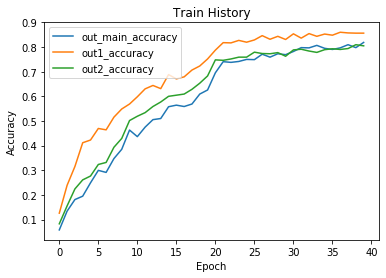

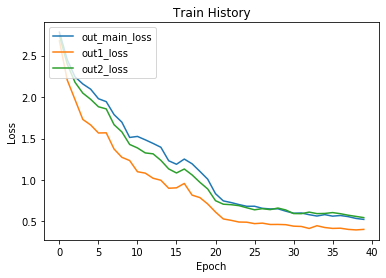

In [15]:
# show train history
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(hist_record, 'Epoch', 'Accuracy', ('out_main_accuracy', 'out1_accuracy', 'out2_accuracy'))
show_train_history(hist_record, 'Epoch', 'Loss', ('out_main_loss', 'out1_loss', 'out2_loss'))